In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.patches import Patch
import seaborn as sns
import scipy.stats as stats
from scipy.stats import kruskal
from scipy.stats import mannwhitneyu
from scipy.stats import sem
from scipy.stats import spearmanr, linregress
import scikit_posthocs as sp

sc._settings.ScanpyConfig(n_jobs=-1)

In [2]:
# Specify the path to your Helvetica Neue Regular font file
helvetica_neue_path = "/home/mstier/.local/share/fonts/HelveticaNeue-Regular.ttf"

# Create a FontProperties object using the font path
prop_neue = fm.FontProperties(fname=helvetica_neue_path)

# Get the font name from FontProperties
helvetica_neue_name = prop_neue.get_name()

# Define custom context for font sizes and line thickness using Seaborn
custom_context = {
    'font.size': 7,                    # General font size for the plot
    'axes.labelsize': 7,               # Font size for axis labels
    'axes.titlesize': 7,               # Font size for titles
    'legend.fontsize': 7,              # Font size for legend
    'axes.linewidth': 0.6,             # Line width for axes spines
    'grid.linewidth': 0.6,             # Line width for grid lines
    'lines.linewidth': 0.6,            # Line width for plot lines
    'lines.markersize': 3,             # Size of markers in scatter/line plots
    'patch.linewidth': 0.6,            # Line width for boxplot edges
    'xtick.major.size': 3,             # Length of major ticks on x-axis
    'ytick.major.size': 3,             # Length of major ticks on y-axis
    'xtick.labelsize': 7,              # Font size for x-tick labels
    'ytick.labelsize': 7,              # Font size for y-tick labels
    'legend.title_fontsize': 7,        # Font size for legend title
}

# Define custom style for aesthetic elements like background, grid, and spines using Seaborn
custom_style = {
    'axes.facecolor': 'white',         # Background color of the axes
    'axes.edgecolor': 'black',         # Color of the border around the plot
    'axes.grid': False,                # Disable gridlines
    'grid.color': '#EAEAEA',           # Color of grid lines
    'grid.linestyle': '--',            # Style of the grid lines (dashed)
    'xtick.color': 'black',            # Color of x-axis tick labels
    'ytick.color': 'black',            # Color of y-axis tick labels
    'ytick.left': True,
    'xtick.bottom': True,
    'xtick.direction': 'out',          # Direction of x-axis ticks
    'ytick.direction': 'out',          # Direction of y-axis ticks
    'axes.spines.left': True,          # Show the left spine (border)
    'axes.spines.bottom': True,        # Show the bottom spine (border)
    'axes.spines.right': False,        # Hide the right spine
    'axes.spines.top': False,          # Hide the top spine
}

# Use set_theme and pass rc with font settings
sns.set_theme(
    context=custom_context,
    style=custom_style,
    rc={
        'font.family': 'sans-serif',                   # Set family to sans-serif
        'font.sans-serif': [helvetica_neue_name],      # Specify Helvetica Neue as the sans-serif font
        'font.size': 7,                                # General font size for the plot
        'axes.labelsize': 7,                           # Font size for axis labels
        'axes.titlesize': 7,                           # Font size for titles
        'legend.fontsize': 7,                          # Font size for legend
        'xtick.labelsize': 7,                          # Font size for x-tick labels
        'ytick.labelsize': 7                           # Font size for y-tick labels
    }
)

plt.rcParams['svg.fonttype'] = 'none'

In [3]:
# Set the base output directory for all figures
output_dir = '/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/ExtDataFigure1/'

Naïve - Kruskal-Wallis H-statistic: 1.94, p-value: 0.3793
Naïve - Dunn’s Post-hoc Test Results:
           CI-NS    CI-Sep       NHC
CI-NS   1.000000  0.754207  1.000000
CI-Sep  0.754207  1.000000  0.780238
NHC     1.000000  0.780238  1.000000

Eff/EM - Kruskal-Wallis H-statistic: 2.54, p-value: 0.2814
Eff/EM - Dunn’s Post-hoc Test Results:
           CI-NS    CI-Sep       NHC
CI-NS   1.000000  1.000000  0.371991
CI-Sep  1.000000  1.000000  0.441572
NHC     0.371991  0.441572  1.000000

CM - Kruskal-Wallis H-statistic: 2.00, p-value: 0.3672
CM - Dunn’s Post-hoc Test Results:
           CI-NS    CI-Sep       NHC
CI-NS   1.000000  0.890914  1.000000
CI-Sep  0.890914  1.000000  0.634425
NHC     1.000000  0.634425  1.000000

Treg - Kruskal-Wallis H-statistic: 2.04, p-value: 0.3606
Treg - Dunn’s Post-hoc Test Results:
           CI-NS    CI-Sep       NHC
CI-NS   1.000000  0.616386  1.000000
CI-Sep  0.616386  1.000000  0.868231
NHC     1.000000  0.868231  1.000000

Th1 - Kruskal-Wallis H-sta

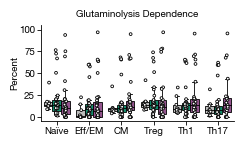

In [6]:
# File path for the SCENITH data
file_path = '/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure1/2024-05-09_SCENITH_D2-CD4.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path, usecols=['SampleID', 'Group', 'CellType', 'MetCat', 'Percent'])

# Ensure 'Percent' is numeric and drop NaN values
df['Percent'] = pd.to_numeric(df['Percent'], errors='coerce')
df = df.dropna(subset=['Percent'])

# Remove 'CD4 T' and 'CD4' from the 'CellType' column and then strip any extra spaces
df['CellType'] = df['CellType'].str.replace('CD4 T ', '').str.replace('CD4', '').str.strip()

# Filter the data to include only 'Gluc Dep' (Glucose Dependence)
df_glut_dep = df[df['MetCat'] == 'Glut Dep']

# Define the cell type order based on preference
cell_type_order = ['Naïve', 'Eff/EM', 'CM', 'Treg', 'Th1', 'Th17']

# Set up the plot dimensions
fig, ax = plt.subplots(figsize=(2.5, 1.25))

# Create the boxplot for Glucose Dependence
sns.boxplot(
    x='CellType', y='Percent', hue='Group', data=df_glut_dep, 
    order=cell_type_order,
    palette={'NHC': '#BBBBBB', 'CI-NS': '#009E73', 'CI-Sep': '#9F4A96'},
    showfliers=False,
    boxprops={'edgecolor': 'black', 'linewidth': 0.6},
    whiskerprops={'color': 'black', 'linewidth': 0.6},
    capprops={'color': 'black', 'linewidth': 0.6},
    medianprops={'color': 'black', 'linewidth': 0.6}
)

# Overlay the individual points using a stripplot
sns.stripplot(
    x='CellType', y='Percent', hue='Group', data=df_glut_dep,
    order=cell_type_order, jitter=True, dodge=True, marker='o',
    size=2, palette=['white'], edgecolor='black', linewidth=0.6
)

# Remove the legend
plt.gca().legend_.remove()

# Customize spines
plt.gca().spines[['top', 'right']].set_visible(False)

# Set y-axis limits and tick labels
plt.ylim(-5, 105)
plt.yticks([0, 25, 50, 75, 100])

# Adjust x-tick and y-tick padding
plt.tick_params(axis='x', direction='out', length=3, width=0.6, pad=1)
plt.tick_params(axis='y', direction='out', length=3, width=0.6, pad=1)

# Adjust y-axis label position
plt.ylabel('Percent', labelpad=0)

# Add title
plt.title('Glutaminolysis Dependence')

# Set the x-axis label to an empty string
plt.xlabel('')

# Perform Kruskal-Wallis test for each cell type and display results
for cell_type in cell_type_order:
    subset = df_glut_dep[df_glut_dep['CellType'] == cell_type]
    
    # Perform Kruskal-Wallis test
    kw_stat, kw_pval = kruskal(
        subset[subset['Group'] == 'NHC']['Percent'],
        subset[subset['Group'] == 'CI-NS']['Percent'],
        subset[subset['Group'] == 'CI-Sep']['Percent']
    )
    print(f'{cell_type} - Kruskal-Wallis H-statistic: {kw_stat:.2f}, p-value: {kw_pval:.4f}')

    # Perform Dunn's post-hoc test
    posthoc_results = sp.posthoc_dunn(
        subset, val_col='Percent', group_col='Group', p_adjust='bonferroni'
    )
    print(f"{cell_type} - Dunn’s Post-hoc Test Results:\n{posthoc_results}\n")

# Save and show the plot
plt.savefig(f'{output_dir}scenith_glutdep.svg', format='svg')
plt.show()


Naïve - Kruskal-Wallis H-statistic: 0.75, p-value: 0.6890
Naïve - Dunn’s Post-hoc Test Results:
        CI-NS  CI-Sep  NHC
CI-NS     1.0     1.0  1.0
CI-Sep    1.0     1.0  1.0
NHC       1.0     1.0  1.0

Eff/EM - Kruskal-Wallis H-statistic: 0.81, p-value: 0.6664
Eff/EM - Dunn’s Post-hoc Test Results:
        CI-NS  CI-Sep  NHC
CI-NS     1.0     1.0  1.0
CI-Sep    1.0     1.0  1.0
NHC       1.0     1.0  1.0

CM - Kruskal-Wallis H-statistic: 1.30, p-value: 0.5226
CM - Dunn’s Post-hoc Test Results:
           CI-NS    CI-Sep       NHC
CI-NS   1.000000  1.000000  0.988386
CI-Sep  1.000000  1.000000  0.777922
NHC     0.988386  0.777922  1.000000

Treg - Kruskal-Wallis H-statistic: 0.98, p-value: 0.6134
Treg - Dunn’s Post-hoc Test Results:
        CI-NS  CI-Sep  NHC
CI-NS     1.0     1.0  1.0
CI-Sep    1.0     1.0  1.0
NHC       1.0     1.0  1.0

Th1 - Kruskal-Wallis H-statistic: 2.35, p-value: 0.3081
Th1 - Dunn’s Post-hoc Test Results:
        CI-NS    CI-Sep       NHC
CI-NS     1.0  1.000

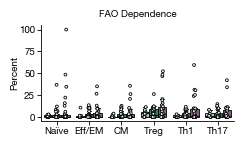

In [7]:
# File path for the SCENITH data
file_path = '/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure1/2024-05-09_SCENITH_D2-CD4.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path, usecols=['SampleID', 'Group', 'CellType', 'MetCat', 'Percent'])

# Ensure 'Percent' is numeric and drop NaN values
df['Percent'] = pd.to_numeric(df['Percent'], errors='coerce')
df = df.dropna(subset=['Percent'])

# Remove 'CD4 T' and 'CD4' from the 'CellType' column and then strip any extra spaces
df['CellType'] = df['CellType'].str.replace('CD4 T ', '').str.replace('CD4', '').str.strip()

# Filter the data to include only 'Gluc Dep' (Glucose Dependence)
df_fao_dep = df[df['MetCat'] == 'FAO Dep']

# Define the cell type order based on preference
cell_type_order = ['Naïve', 'Eff/EM', 'CM', 'Treg', 'Th1', 'Th17']

# Set up the plot dimensions
fig, ax = plt.subplots(figsize=(2.5, 1.25))

# Create the boxplot for Glucose Dependence
sns.boxplot(
    x='CellType', y='Percent', hue='Group', data=df_fao_dep, 
    order=cell_type_order,
    palette={'NHC': '#BBBBBB', 'CI-NS': '#009E73', 'CI-Sep': '#9F4A96'},
    showfliers=False,
    boxprops={'edgecolor': 'black', 'linewidth': 0.6},
    whiskerprops={'color': 'black', 'linewidth': 0.6},
    capprops={'color': 'black', 'linewidth': 0.6},
    medianprops={'color': 'black', 'linewidth': 0.6}
)

# Overlay the individual points using a stripplot
sns.stripplot(
    x='CellType', y='Percent', hue='Group', data=df_fao_dep,
    order=cell_type_order, jitter=True, dodge=True, marker='o',
    size=2, palette=['white'], edgecolor='black', linewidth=0.6
)

# Remove the legend
plt.gca().legend_.remove()

# Customize spines
plt.gca().spines[['top', 'right']].set_visible(False)

# Set y-axis limits and tick labels
plt.ylim(-5, 105)
plt.yticks([0, 25, 50, 75, 100])

# Adjust x-tick and y-tick padding
plt.tick_params(axis='x', direction='out', length=3, width=0.6, pad=1)
plt.tick_params(axis='y', direction='out', length=3, width=0.6, pad=1)

# Adjust y-axis label position
plt.ylabel('Percent', labelpad=0)

# Add title
plt.title('FAO Dependence')

# Set the x-axis label to an empty string
plt.xlabel('')

# Perform Kruskal-Wallis test for each cell type and display results
for cell_type in cell_type_order:
    subset = df_fao_dep[df_fao_dep['CellType'] == cell_type]
    
    # Perform Kruskal-Wallis test
    kw_stat, kw_pval = kruskal(
        subset[subset['Group'] == 'NHC']['Percent'],
        subset[subset['Group'] == 'CI-NS']['Percent'],
        subset[subset['Group'] == 'CI-Sep']['Percent']
    )
    print(f'{cell_type} - Kruskal-Wallis H-statistic: {kw_stat:.2f}, p-value: {kw_pval:.4f}')

    # Perform Dunn's post-hoc test
    posthoc_results = sp.posthoc_dunn(
        subset, val_col='Percent', group_col='Group', p_adjust='bonferroni'
    )
    print(f"{cell_type} - Dunn’s Post-hoc Test Results:\n{posthoc_results}\n")

# Save and show the plot
plt.savefig(f'{output_dir}scenith_faodep.svg', format='svg')
plt.show()